# Quick Start

Here's a quick tutorial for those in a rush!

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import hemcee

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import numpy as np
import corner

First, specifiy the log probability (doesn't have to be normalized)
of your target distribution.
In this case, let's start with a simple Gaussian.

In [32]:
def log_prob(x):
    return - 0.5 * jnp.einsum('j,j->', x, x)

Now we can initalize the sampler. There are two types of samplers `hemcee.HamiltonianEnsembleSampeler` and `hemcee.EnsembleSampler`.
The `HamiltonianEnsembleSampler` implements the derivative-based algorithms detailed in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987), and the `EnsembleSampler` implements the derivative-free algorithms detailed in [Goodman & Weare (2010)](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-s.pdf) (for python implementation see [`emcee`](https://emcee.readthedocs.io/en/stable/))

Let's start with the novel part of this package...

# `HamiltonianEnsembleSampler`
In Chen's paper, he details a couple of affine invariant sampling scheme. He comes to the conclusion that the walk move (Algorithm 3 in [Y. Chen (2025)](https://arxiv.org/abs/2505.02987)) performs the best overall, so our package defaults to that.

In [33]:
dim = 3
total_chains = 20

# Hamiltonian Monte Carlo hyperparameters
step_size: float = 0.1 # Step size of leapfrog integrator
L: int = 10            # Number of leapfrog steps

# Inintalize the sampler
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim, # <- dimension of the probability distribution
    log_prob=log_prob, # <- log probability goes here!
    step_size=step_size,
    L=L,
)

Now, we can run the sampler!

In [34]:
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 2)

inital_states = jax.random.normal(keys[0], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[1], # <- JAX is used under the hood, so we need to pass in a `key`
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)
print(sampler.diagnostics_main)

Using 20 total chains: Group 1 (10), Group 2 (10)
{'accepts': Array([79653., 79618., 79623., 79899., 79706., 79637., 79794., 79544.,
       79888., 79463., 79804., 79583., 79586., 79637., 79527., 79649.,
       79508., 79534., 79669., 79530.], dtype=float64), 'acceptance_rate': Array([0.79653, 0.79618, 0.79623, 0.79899, 0.79706, 0.79637, 0.79794,
       0.79544, 0.79888, 0.79463, 0.79804, 0.79583, 0.79586, 0.79637,
       0.79527, 0.79649, 0.79508, 0.79534, 0.79669, 0.7953 ],      dtype=float64)}


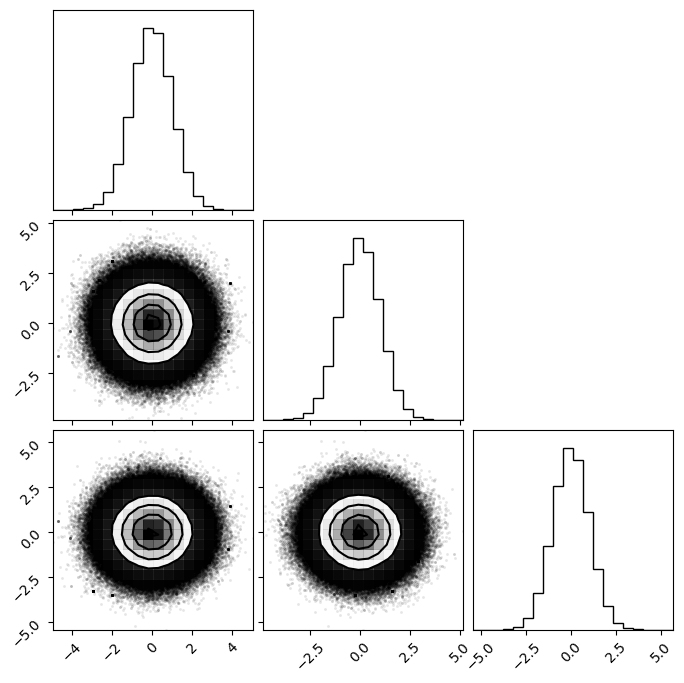

In [35]:
# Visualize results using `corner`
_ = corner.corner(np.array(samples.reshape(-1, dim)))

But this is way too easy, let's try to sample a highly skewed distribution. 

In [36]:
# Settings
dim = 7
total_chains = dim * 6
cond_number = 1000 # Condition number of covariance matrix

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)


# Distribution
eigenvals = 0.1 * jnp.linspace(1, cond_number, dim)
H = jax.random.normal(keys[0], shape=(dim, dim))
Q, _ = np.linalg.qr(H)
precision = Q @ np.diag(eigenvals) @ Q.T
precision = 0.5 * (precision + precision.T)

true_mean = jax.random.normal(keys[1], shape=(dim,))
precision_matrix = jnp.array(precision)

def log_prob(x):
    """Vectorized log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = - 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler

sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=0.1,
    L=10,
)

inital_states = jax.random.normal(keys[2], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[3],
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)
print(sampler.diagnostics_main)


Using 42 total chains: Group 1 (21), Group 2 (21)
{'accepts': Array([80145., 79890., 80041., 79774., 80155., 80031., 79962., 79951.,
       79894., 80205., 80036., 79942., 80085., 79658., 80095., 80162.,
       80030., 79713., 80202., 79910., 80136., 79912., 80186., 80053.,
       80174., 80092., 79723., 79958., 80256., 80309., 79936., 79926.,
       80130., 80048., 80136., 80007., 79849., 80016., 80140., 79993.,
       79843., 79801.], dtype=float64), 'acceptance_rate': Array([0.80145, 0.7989 , 0.80041, 0.79774, 0.80155, 0.80031, 0.79962,
       0.79951, 0.79894, 0.80205, 0.80036, 0.79942, 0.80085, 0.79658,
       0.80095, 0.80162, 0.8003 , 0.79713, 0.80202, 0.7991 , 0.80136,
       0.79912, 0.80186, 0.80053, 0.80174, 0.80092, 0.79723, 0.79958,
       0.80256, 0.80309, 0.79936, 0.79926, 0.8013 , 0.80048, 0.80136,
       0.80007, 0.79849, 0.80016, 0.8014 , 0.79993, 0.79843, 0.79801],      dtype=float64)}


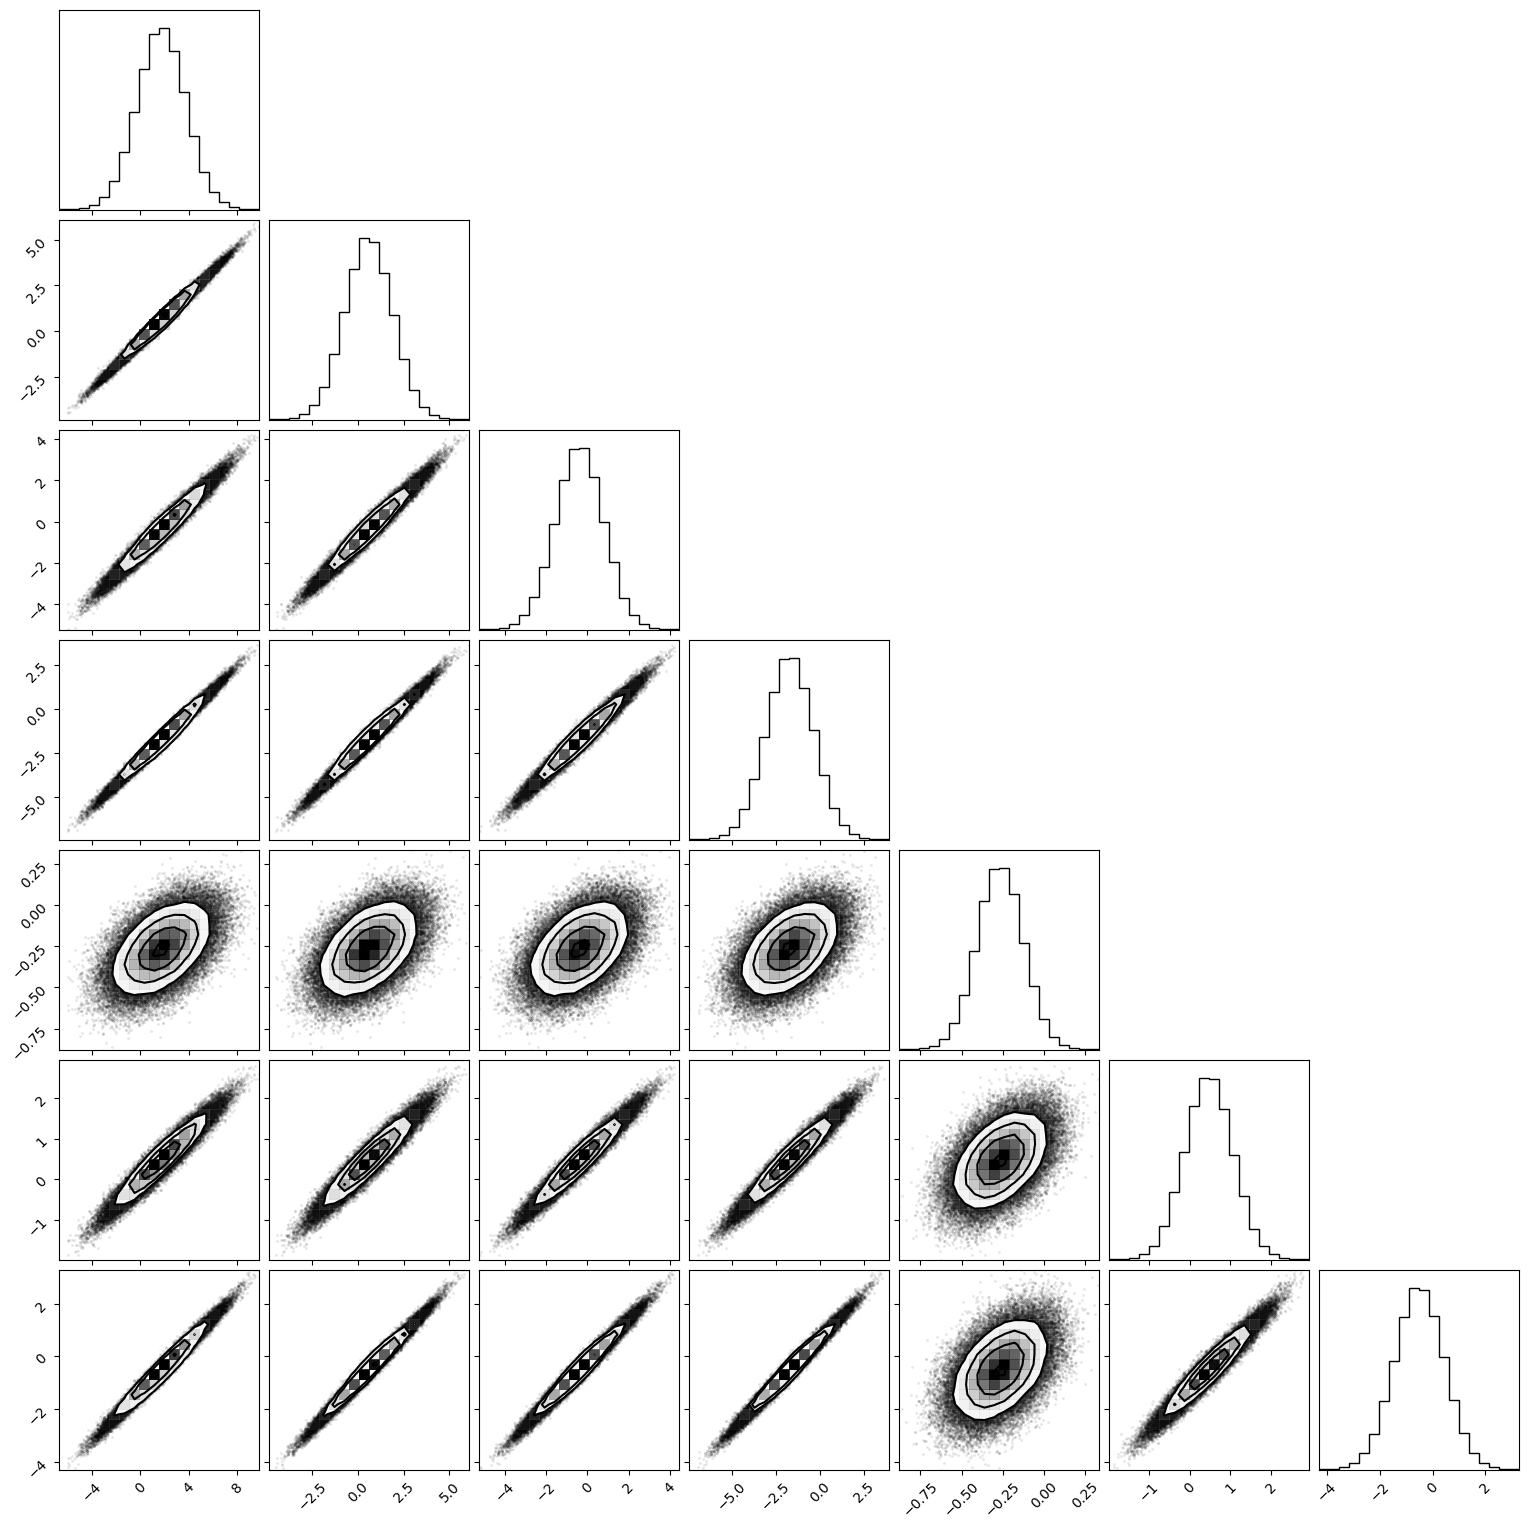

In [37]:
n_show = 100000 # Makes plotting faster
_ = corner.corner(np.array(samples.reshape(-1, dim))[:n_show])

# Rosenbrock

In [ ]:
from hemcee.tests.distribution import make_rosenbrock
from hemcee.moves.hamiltonian.hmc_side import hmc_side_move

keys = jax.random.split(jax.random.PRNGKey(0), 4)
total_chains = 26
dim = 5 

log_prob  = make_rosenbrock(jax.random.PRNGKey(0))

sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    step_size=0.01,
    L=15,
)

inital_states = jax.random.normal(keys[2], shape=(total_chains, dim))

samples = sampler.run_mcmc(
    key=keys[3],
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
    adapt_step_size = True,
)
print(sampler.da_state)
print(sampler.diagnostics_main)

Using 26 total chains: Group 1 (13), Group 2 (13)
DAState(iteration=Array(100000, dtype=int64, weak_type=True), step_size=Array(0.11920759, dtype=float64), H_bar=Array(0.0003442, dtype=float64), log_epsilon_bar=Array(-2.14661866, dtype=float64))
{'accepts': Array([67058., 68525., 68179., 67037., 69119., 69416., 67544., 68520.,
       67406., 68456., 70353., 70407., 67260., 67935., 69331., 66959.,
       67768., 68969., 67065., 69068., 67874., 69009., 68478., 68374.,
       69636., 70479.], dtype=float64), 'acceptance_rate': Array([0.67058, 0.68525, 0.68179, 0.67037, 0.69119, 0.69416, 0.67544,
       0.6852 , 0.67406, 0.68456, 0.70353, 0.70407, 0.6726 , 0.67935,
       0.69331, 0.66959, 0.67768, 0.68969, 0.67065, 0.69068, 0.67874,
       0.69009, 0.68478, 0.68374, 0.69636, 0.70479], dtype=float64)}


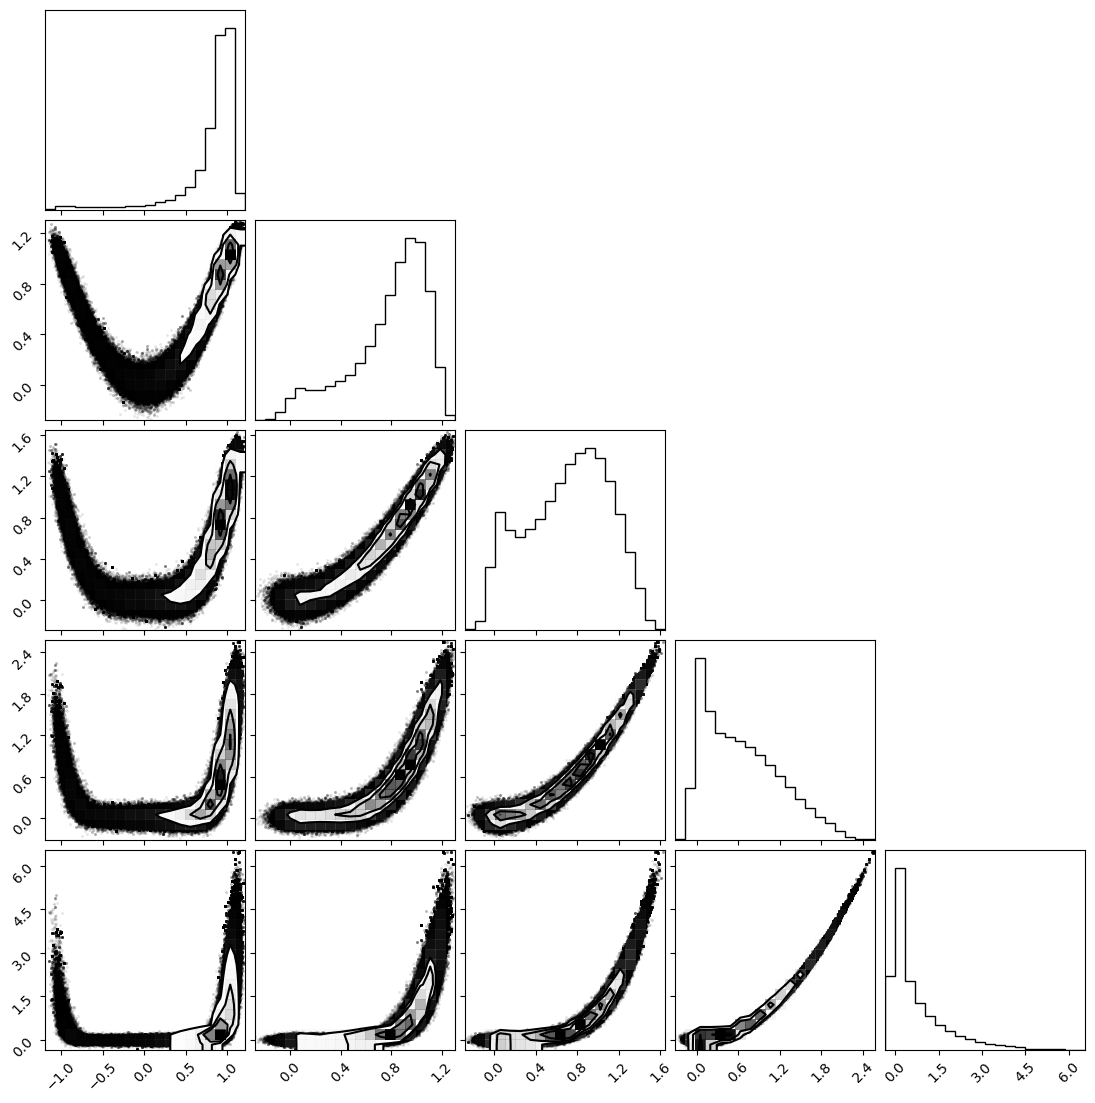

In [66]:
_ = corner.corner(np.array(samples.reshape(-1, dim)))

In [44]:
from hemcee.moves.vanilla.walk import walk_move

sampler = hemcee.EnsembleSampler(
    total_chains=total_chains,
    dim=dim,
    log_prob=log_prob,
    move=walk_move,
)

samples = sampler.run_mcmc(
    key=jax.random.PRNGKey(0),
    initial_state=inital_states,
    num_samples=10**5,
    warmup=10**5,
)

Using 26 total chains: Group 1 (13), Group 2 (13)


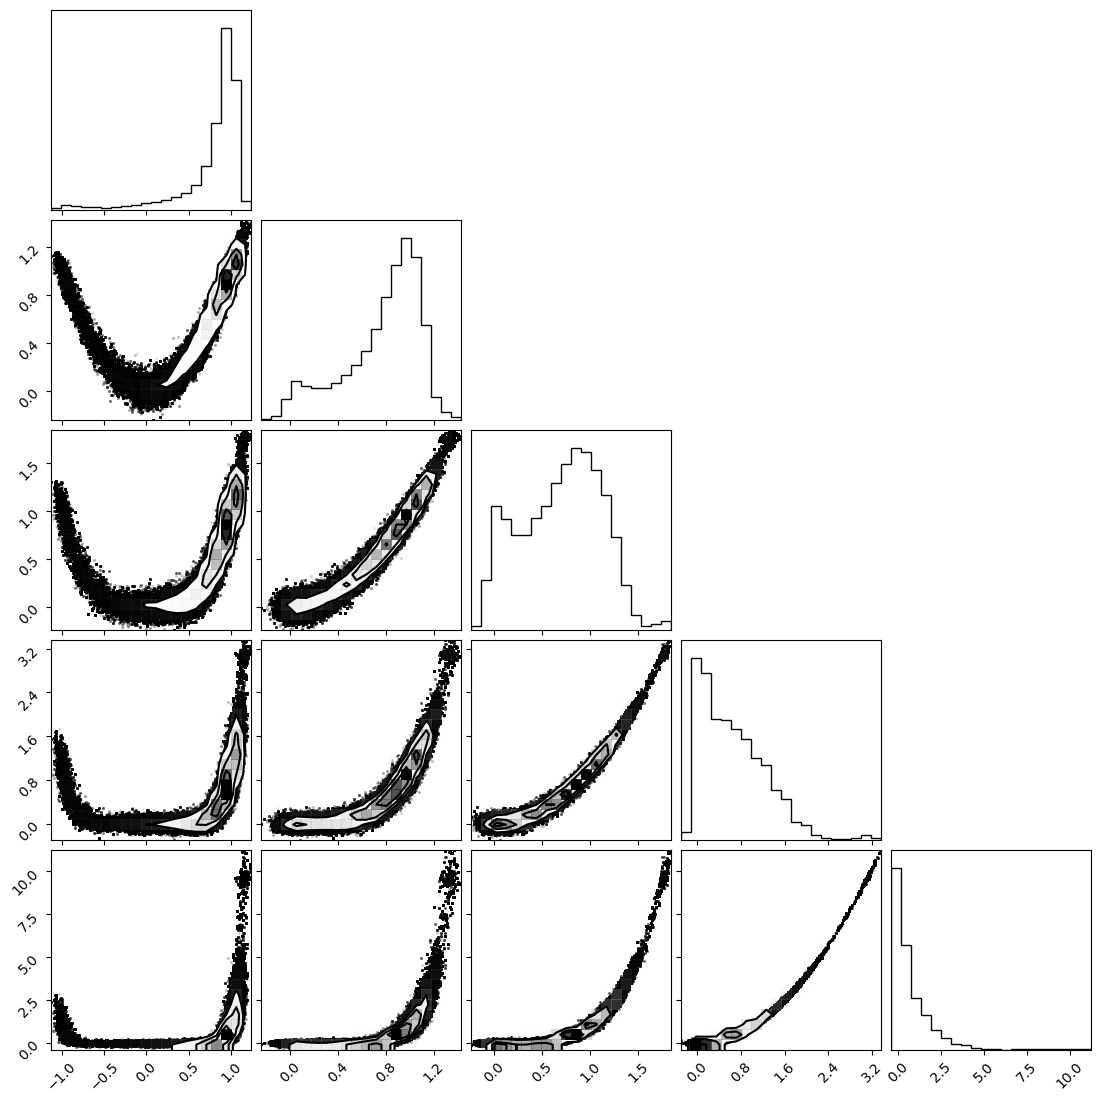

In [45]:
_ = corner.corner(np.array(samples.reshape(-1, dim)))